In [1]:
import pyreadr 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
pwd

'/Users/lourizzolo/code/LouR238/coronanet/Notebooks'

In [3]:
ls

Exploration_1.ipynb                 Notebook1
Laurent_DataExploration.ipynb       Tristan_EDA.ipynb
Lou_data_exploration.ipynb          Unified_data_time_series_Lou.ipynb


In [4]:
df = pyreadr.read_r('../data/COVID-19.RData') # also works for Rds
print(df.keys()) # let’s check what objects we got

odict_keys(['COVID19'])


In [5]:
df =df['COVID19']

In [6]:
print(df.columns)
print(df.shape)
print(df.dtypes)

Index(['ID', 'Date', 'Cases', 'Cases_New', 'Type', 'Age', 'Sex', 'Source'], dtype='object')
(7521587, 8)
ID           object
Date         object
Cases        object
Cases_New    object
Type         object
Age          object
Sex          object
Source       object
dtype: object


In [7]:
df_fr = df[df['ID']=='FR']

In [8]:
print(df_fr.shape)

(1272, 8)


# data preprocessing for time series

In [9]:
df_fr = df_fr[['Date','Cases_New']]
df_fr.head()

,Date,Cases_New
2970263,2020-01-22,0
2970264,2020-01-22,0
2970265,2020-01-22,0
2970266,2020-01-22,0
2970267,2020-01-23,0


In [10]:
df_fr['Date'] = pd.to_datetime(df_fr['Date'])

In [11]:
print(df_fr.dtypes)

Date         datetime64[ns]
Cases_New            object
dtype: object


# Analyses entre Juin et Novembre

In [12]:
start_date = '2020-06-01'
end_date = '2020-11-30'

In [13]:
mask = (df_fr['Date'] > start_date) & (df_fr['Date'] <= end_date)

In [14]:
df_fr1 = df_fr.loc[mask]
df_fr.shape

(1272, 2)

In [15]:
df_fr1.reset_index()
df_fr1 = df_fr1.set_index(df_fr1["Date"])
df_fr1 = df_fr1.drop("Date", axis=1)
df_fr1.shape

(728, 1)

In [16]:
df_fr1 = df_fr1.groupby("Date").sum()
df_fr1.shape

(182, 1)

In [17]:
df_fr1["Cases_New"].isnull().sum()

0

<AxesSubplot:xlabel='Date'>

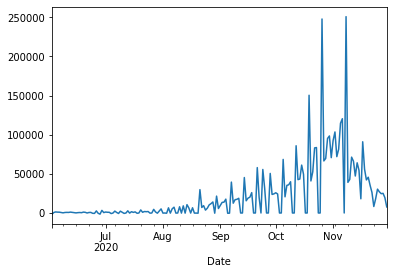

In [18]:
df_fr1["Cases_New"].plot()

In [19]:
size = round(df_fr1.shape[0]*0.7)

In [20]:
df_train1 = df_fr1[:size]
df_test1 = df_fr1[size:]
print(df_train1.shape)
print(df_test1.shape)

(127, 1)
(55, 1)


In [21]:
from statsmodels.tsa.stattools import adfuller
print('p-value: ', adfuller(df_train1["Cases_New"])[1])

p-value:  0.9954847669962018


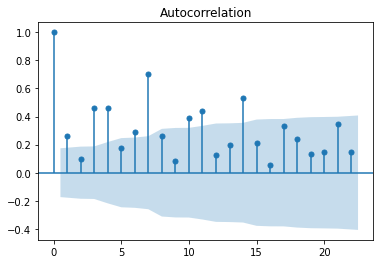

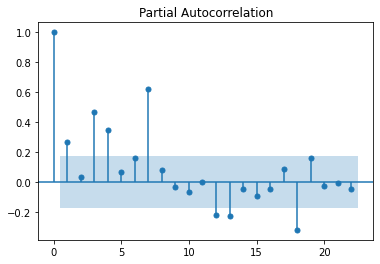

In [22]:
y1 = df_train1.Cases_New
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y1);
plot_pacf(y1);

In [23]:
y_diff_7_1 = df_train1.Cases_New.diff(7).dropna()

p-value:  0.0029614374130666294


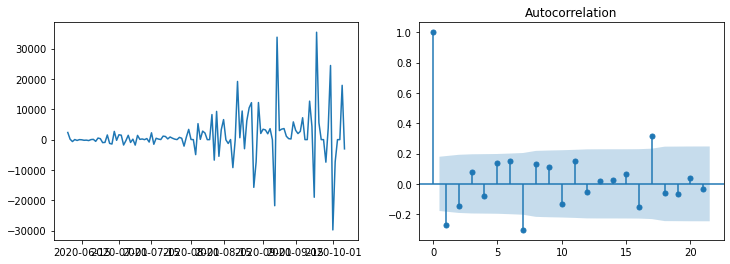

In [24]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(y_diff_7_1)
plot_acf(y_diff_7_1, ax=axes[1])
print('p-value: ', adfuller(y_diff_7_1)[1])

p-value:  1.4473586480741353e-07


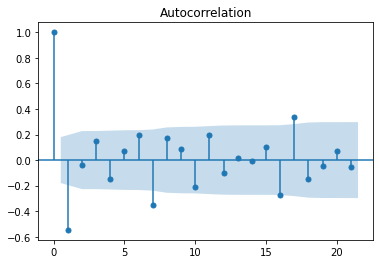

In [25]:
plot_acf(y_diff_7_1.diff(1).dropna());
print('p-value: ', adfuller(y_diff_7_1.diff(1).dropna())[1])

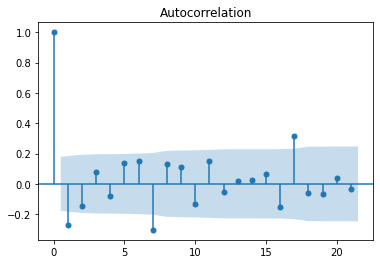

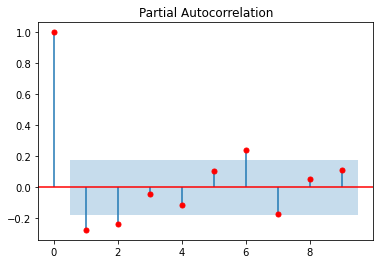

In [26]:
plot_acf(y_diff_7_1);
plot_pacf(y_diff_7_1, lags=np.arange(10), c='red');

In [27]:
model = pm.auto_arima(df_train1['Cases_New'],
                      m=52, # frequency of series. Important to choose manually
                      seasonal=True,
                      stepwise=True,  # only check most interesting combination. False will take way longer.
                      start_p=0, max_p=2,
                      start_d=0, max_d=1,
                      start_q=0, max_q=2,
                      start_P=0, max_P=2,
                      start_D=0, max_D=2,
                      start_Q=0, max_Q=2,
                      njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True)
print(model.summary())

/Users/lourizzolo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/pmdarima/arima/utils.py:120: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (23) is shorter than m (52). Using D=2
  % (len(x), m, D))


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,2,0)[52]             : AIC=538.283, Time=1.89 sec
 ARIMA(1,0,0)(1,2,0)[52]             : AIC=inf, Time=18.57 sec
 ARIMA(0,0,1)(0,2,1)[52]             : AIC=536.418, Time=8.34 sec
 ARIMA(0,0,1)(0,2,0)[52]             : AIC=534.585, Time=1.82 sec
 ARIMA(0,0,1)(1,2,0)[52]             : AIC=536.248, Time=11.96 sec
 ARIMA(0,0,1)(1,2,1)[52]             : AIC=538.118, Time=32.12 sec
 ARIMA(1,0,1)(0,2,0)[52]             : AIC=529.274, Time=8.22 sec
 ARIMA(1,0,1)(1,2,0)[52]             : AIC=531.271, Time=29.87 sec
 ARIMA(1,0,1)(0,2,1)[52]             : AIC=530.118, Time=61.05 sec
 ARIMA(1,0,1)(1,2,1)[52]             : AIC=inf, Time=128.65 sec
 ARIMA(1,0,0)(0,2,0)[52]             : AIC=534.494, Time=3.98 sec
 ARIMA(2,0,1)(0,2,0)[52]             : AIC=529.665, Time=28.63 sec
 ARIMA(1,0,2)(0,2,0)[52]             : AIC=528.045, Time=8.20 sec
 ARIMA(1,0,2)(1,2,0)[52]             : AIC=552.651, Time=69.32 sec
 ARIMA(1,0,2)(0,2,1)[52]        

In [28]:
# Forecast
n_periods = len(df_test1)
central, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_y_test = df_test1.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

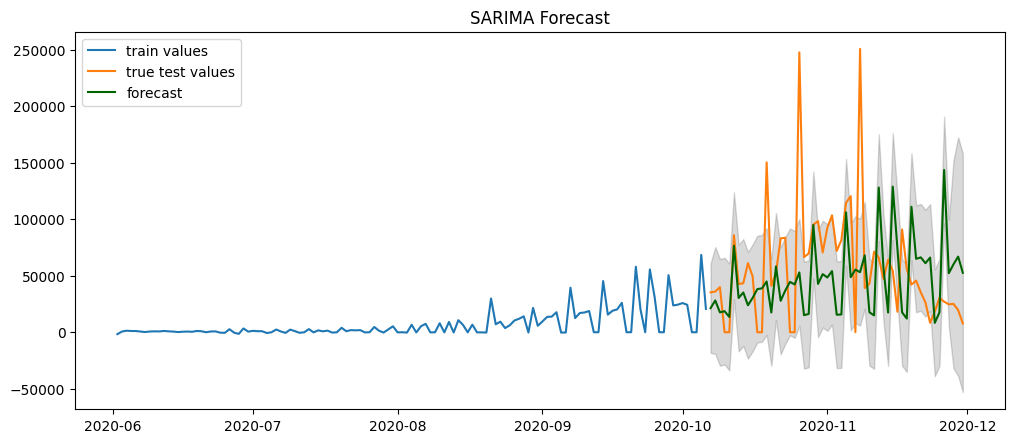

In [29]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train1, label = "train values")
plt.plot(df_test1, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [30]:
model_2 = pm.auto_arima(df_train1['Cases_New'],
                      m=7, # frequency of series. Important to choose manually
                      seasonal=True,
                      stepwise=True,  # only check most interesting combination. False will take way longer.
                      start_p=0, max_p=2,
                      start_d=0, max_d=1,
                      start_q=0, max_q=2,
                      start_P=0, max_P=2,
                      start_D=0, max_D=2,
                      start_Q=0, max_Q=2,
                      njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True)
print(model_2.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2580.963, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=2521.925, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=2469.825, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=2470.825, Time=0.16 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=2470.736, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=2459.321, Time=0.29 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=2470.846, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=2472.818, Time=0.33 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=2560.813, Time=0.03 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=2453.171, Time=0.33 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=2473.331, Time=0.06 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=2467.312, Time=0.26 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=2467.312, Time=0.17 sec
 ARIMA(1,1,1)(0,1,1)[7]             : 

In [31]:
# Forecast
n_periods = len(df_test1)
central, confint = model_2.predict(n_periods=n_periods, return_conf_int=True)
index_y_test = df_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

NameError: name 'df_test' is not defined

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train1, label = "train values")
plt.plot(df_test1, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [ ]:
model_3 = pm.auto_arima(df_train1['Cases_New'],
                      m=12, # frequency of series. Important to choose manually
                      seasonal=True,
                      stepwise=True,  # only check most interesting combination. False will take way longer.
                      start_p=0, max_p=2,
                      start_d=0, max_d=1,
                      start_q=0, max_q=2,
                      start_P=0, max_P=2,
                      start_D=0, max_D=2,
                      start_Q=0, max_Q=2,
                      njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True)
print(model_3.summary())

In [ ]:
# Forecast
n_periods = len(df_test1)
central, confint = model_3.predict(n_periods=n_periods, return_conf_int=True)
index_y_test = df_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train1, label = "train values")
plt.plot(df_test1, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [ ]:
model_4 = pm.auto_arima(df_train1['Cases_New'],
                      m=27, # frequency of series. Important to choose manually
                      seasonal=True,
                      stepwise=True,  # only check most interesting combination. False will take way longer.
                      start_p=0, max_p=2,
                      start_d=0, max_d=1,
                      start_q=0, max_q=2,
                      start_P=0, max_P=2,
                      start_D=0, max_D=2,
                      start_Q=0, max_Q=2,
                      njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True)
print(model_4.summary())

In [ ]:
# Forecast
n_periods = len(df_test1)
central, confint = model_4.predict(n_periods=n_periods, return_conf_int=True)
index_y_test = df_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train1, label = "train values")
plt.plot(df_test1, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [ ]:
model_5 = pm.auto_arima(df_train1['Cases_New'],
                      m=52*2, # frequency of series. Important to choose manually
                      seasonal=True,
                      stepwise=True,  # only check most interesting combination. False will take way longer.
                      start_p=0, max_p=2,
                      start_d=0, max_d=1,
                      start_q=0, max_q=2,
                      start_P=0, max_P=2,
                      start_D=0, max_D=2,
                      start_Q=0, max_Q=2,
                      njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True)
print(model_5.summary())

# période avec moins de variations 

In [ ]:
start_date = '2020-06-01'
end_date = '2020-09-29'

In [ ]:
mask_2 = (df_fr['Date'] > start_date) & (df_fr['Date'] <= end_date)